# 02 — Synthetic User & Interaction Data Generation
## Fitness Workout Recommender

Since no 'MovieLens for fitness' exists, we generate synthetic but realistic data.
This notebook:
1. Creates 1,000 user profiles with fitness goals & preferences
2. Simulates user-exercise interactions using logical preference rules
3. Validates the generated data
4. Exports everything for modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
np.random.seed(42)
print('Libraries loaded!')

Libraries loaded!


In [2]:
# Load the enriched exercise dataset from notebook 01
exercises = pd.read_csv('../data/processed/exercises_clean.csv')
print(f'Loaded {len(exercises)} exercises')
exercises.head()

Loaded 52 exercises


,exercise_id,exercise_name,body_part,muscle_type,equipment,movement_type,movement_pattern,difficulty,sets_min,sets_max,reps_min,reps_max,est_duration_min
0,0,incline dumbbell press,chest,upper chest,dumbbells,compound,push,intermediate,3.0,4.0,8,12,7.4
1,1,incline cable crossovers,chest,upper chest,machine,isolation,push,beginner,3.0,4.0,10,15,8.0
2,2,incline dumbbell flyes,chest,upper chest,dumbbells,isolation,push,beginner,3.0,4.0,10,15,8.0
3,3,decline dumbbell press,chest,lower chest,dumbbells,compound,push,intermediate,3.0,4.0,8,12,7.4
4,4,decline cable crossovers,chest,lower chest,machine,isolation,push,beginner,3.0,4.0,10,15,8.0


## 1. Generate User Profiles

Each user has attributes that determine which exercises they'd prefer.
The distributions are chosen to be realistic (e.g., more beginners than advanced).

In [3]:
FITNESS_GOALS = ['weight_loss', 'muscle_gain', 'endurance', 'flexibility', 'general_fitness']
FITNESS_LEVELS = ['beginner', 'intermediate', 'advanced']
EQUIPMENT_ACCESS = ['bodyweight_only', 'dumbbells', 'full_gym', 'home_gym']
TIME_AVAILABLE = [15, 30, 45, 60, 90]
BODY_FOCUS = ['upper', 'lower', 'full', 'core']
AGE_GROUPS = ['young_adult', 'adult', 'senior']

N_USERS = 1000

users = pd.DataFrame({
    'user_id': [f'user_{i:04d}' for i in range(N_USERS)],
    'fitness_goal': np.random.choice(FITNESS_GOALS, N_USERS, p=[0.30, 0.25, 0.15, 0.10, 0.20]),
    'fitness_level': np.random.choice(FITNESS_LEVELS, N_USERS, p=[0.40, 0.40, 0.20]),
    'equipment_access': np.random.choice(EQUIPMENT_ACCESS, N_USERS, p=[0.25, 0.25, 0.35, 0.15]),
    'time_per_session': np.random.choice(TIME_AVAILABLE, N_USERS, p=[0.10, 0.30, 0.30, 0.20, 0.10]),
    'preferred_body_focus': np.random.choice(BODY_FOCUS, N_USERS, p=[0.25, 0.25, 0.35, 0.15]),
    'age_group': np.random.choice(AGE_GROUPS, N_USERS, p=[0.35, 0.45, 0.20]),
})

print(f'Generated {len(users)} user profiles')
users.head(10)

Generated 1000 user profiles


,user_id,fitness_goal,fitness_level,equipment_access,time_per_session,preferred_body_focus,age_group
0,user_0000,muscle_gain,beginner,dumbbells,45,full,adult
1,user_0001,general_fitness,intermediate,bodyweight_only,60,full,adult
2,user_0002,flexibility,advanced,home_gym,30,full,senior
3,user_0003,endurance,intermediate,bodyweight_only,45,upper,young_adult
4,user_0004,weight_loss,advanced,dumbbells,45,upper,senior
5,user_0005,weight_loss,intermediate,full_gym,60,lower,young_adult
6,user_0006,weight_loss,intermediate,dumbbells,90,lower,adult
7,user_0007,general_fitness,advanced,full_gym,15,lower,senior
8,user_0008,endurance,beginner,bodyweight_only,45,full,young_adult
9,user_0009,flexibility,intermediate,dumbbells,15,upper,adult


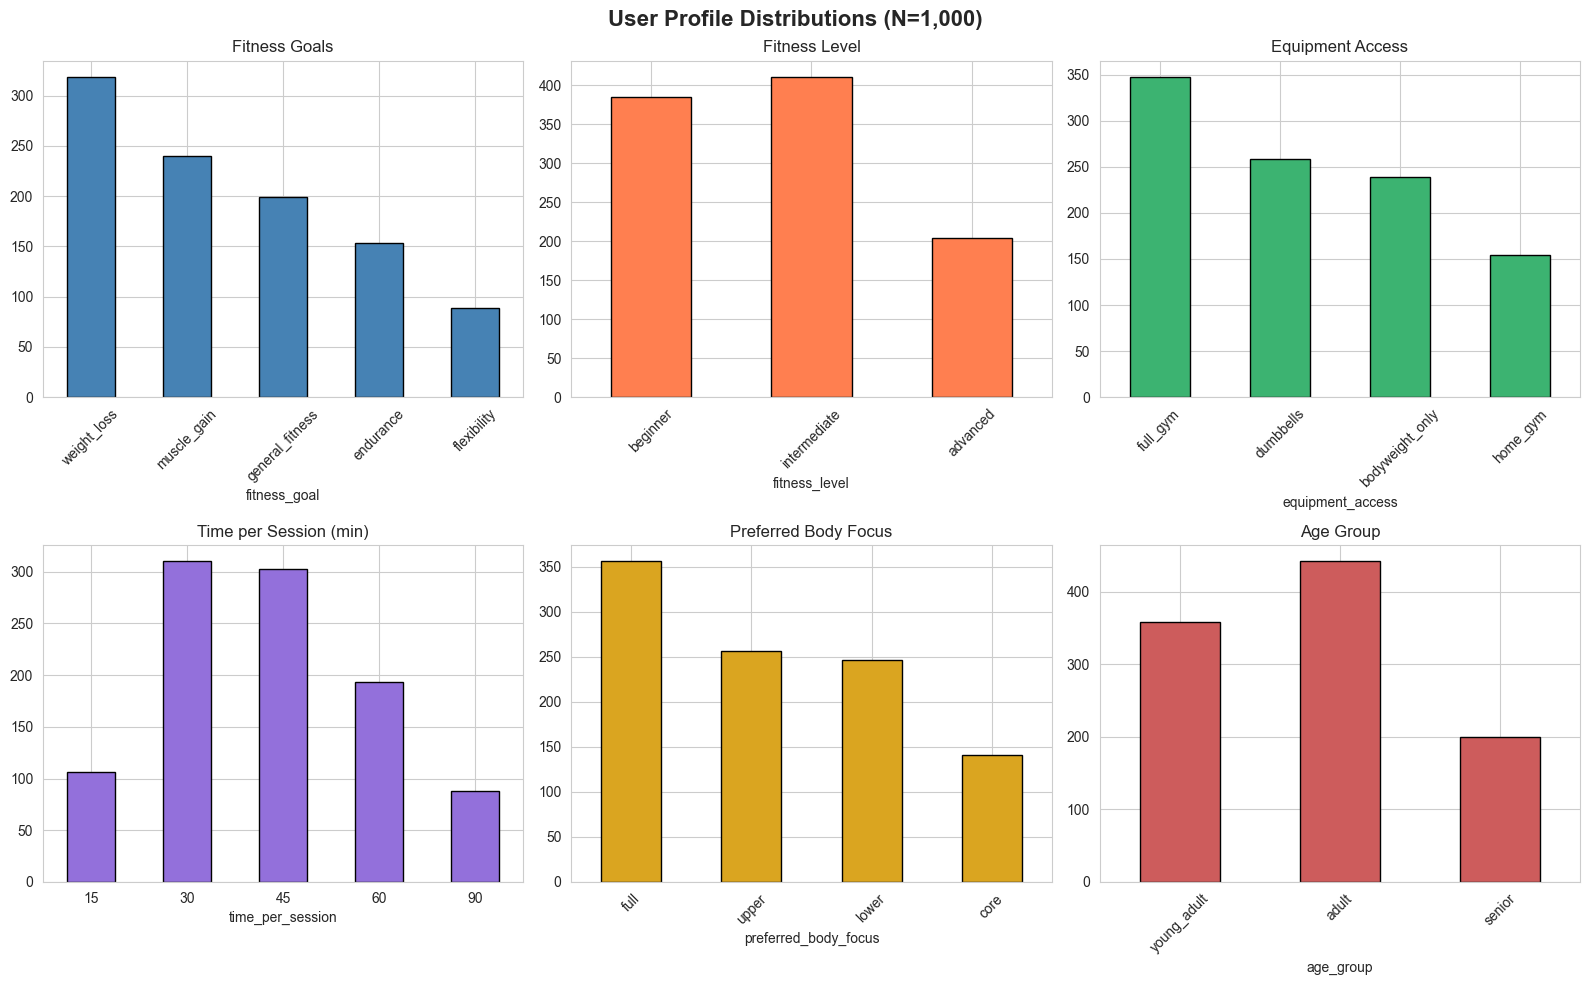

In [4]:
# Visualize user distributions
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('User Profile Distributions (N=1,000)', fontsize=16, fontweight='bold')

users['fitness_goal'].value_counts().plot.bar(ax=axes[0,0], color='steelblue', edgecolor='black')
axes[0,0].set_title('Fitness Goals')
axes[0,0].tick_params(axis='x', rotation=45)

users['fitness_level'].value_counts().reindex(['beginner','intermediate','advanced']).plot.bar(ax=axes[0,1], color='coral', edgecolor='black')
axes[0,1].set_title('Fitness Level')
axes[0,1].tick_params(axis='x', rotation=45)

users['equipment_access'].value_counts().plot.bar(ax=axes[0,2], color='mediumseagreen', edgecolor='black')
axes[0,2].set_title('Equipment Access')
axes[0,2].tick_params(axis='x', rotation=45)

users['time_per_session'].value_counts().sort_index().plot.bar(ax=axes[1,0], color='mediumpurple', edgecolor='black')
axes[1,0].set_title('Time per Session (min)')
axes[1,0].tick_params(axis='x', rotation=0)

users['preferred_body_focus'].value_counts().plot.bar(ax=axes[1,1], color='goldenrod', edgecolor='black')
axes[1,1].set_title('Preferred Body Focus')
axes[1,1].tick_params(axis='x', rotation=45)

users['age_group'].value_counts().reindex(['young_adult','adult','senior']).plot.bar(ax=axes[1,2], color='indianred', edgecolor='black')
axes[1,2].set_title('Age Group')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../results/figures/04_user_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Define Preference Rules

These rules simulate how real users would choose exercises.
Each rule adds or subtracts from a base preference score.

**This is a key part of the project** — document your reasoning for each rule,
as admissions reviewers will want to see you can justify design decisions.

In [5]:
def compute_preference_score(user, exercise):
    """
    Compute a preference score (0-1) for a user-exercise pair.
    Based on logical fitness rules.
    """
    score = 0.5  # neutral baseline
    
    # --- Rule 1: Difficulty should match fitness level ---
    diff_map = {
        'beginner':      {'beginner': 0.15, 'intermediate': 0.0,  'advanced': -0.20},
        'intermediate':  {'beginner': -0.05, 'intermediate': 0.15, 'advanced': 0.05},
        'advanced':      {'beginner': -0.15, 'intermediate': 0.05, 'advanced': 0.15},
    }
    user_level = user['fitness_level']
    ex_diff = exercise['difficulty']
    score += diff_map.get(user_level, {}).get(ex_diff, 0)
    
    # --- Rule 2: Equipment compatibility ---
    equip_compat = {
        'bodyweight_only': {'bodyweight': 0.2, 'pull-up bar': 0.05, 'dumbbells': -0.3, 'barbell': -0.3, 'machine': -0.3, 'other': -0.1},
        'dumbbells':       {'bodyweight': 0.1, 'dumbbells': 0.2, 'pull-up bar': 0.05, 'barbell': -0.2, 'machine': -0.2, 'other': 0.0},
        'home_gym':        {'bodyweight': 0.1, 'dumbbells': 0.15, 'barbell': 0.15, 'pull-up bar': 0.1, 'machine': -0.1, 'other': 0.05},
        'full_gym':        {'bodyweight': 0.05, 'dumbbells': 0.1, 'barbell': 0.15, 'machine': 0.15, 'pull-up bar': 0.1, 'other': 0.05},
    }
    user_equip = user['equipment_access']
    ex_equip = exercise['equipment']
    score += equip_compat.get(user_equip, {}).get(ex_equip, 0)
    
    # --- Rule 3: Body part preference ---
    body = exercise['body_part']
    focus = user['preferred_body_focus']
    if focus == 'upper' and body in ['chest', 'back', 'shoulders', 'arms']:
        score += 0.1
    elif focus == 'lower' and body == 'legs':
        score += 0.15
    elif focus == 'core' and body == 'core':
        score += 0.15
    elif focus == 'full':
        score += 0.05  # slight boost for everything
    
    # --- Rule 4: Goal alignment with movement type ---
    goal = user['fitness_goal']
    if goal == 'muscle_gain' and exercise['movement_type'] == 'compound':
        score += 0.1
    elif goal == 'muscle_gain' and exercise['movement_type'] == 'isolation':
        score += 0.05
    elif goal == 'weight_loss' and exercise['movement_type'] == 'compound':
        score += 0.1  # compound burns more calories
    elif goal == 'endurance' and exercise['reps_max'] and exercise['reps_max'] >= 15:
        score += 0.1
    elif goal == 'flexibility':
        if exercise['movement_type'] == 'isolation':
            score += 0.05
    
    # --- Rule 5: Age group adjustments ---
    if user['age_group'] == 'senior':
        if ex_diff == 'advanced':
            score -= 0.15
        if ex_equip == 'bodyweight':
            score += 0.05
    elif user['age_group'] == 'young_adult':
        if ex_diff == 'advanced':
            score += 0.05
    
    # --- Add noise for realism ---
    score += np.random.normal(0, 0.08)
    
    return np.clip(score, 0.05, 0.99)

print('Preference function defined!')

Preference function defined!


## 3. Generate Interactions

For each user, we compute preference scores for all exercises,
then sample interactions proportional to those scores.
This simulates a world where users try exercises they're more likely to enjoy.

In [6]:
from tqdm import tqdm

INTERACTIONS_PER_USER = 15  # Each user interacts with ~15 exercises

interactions = []

for _, user in tqdm(users.iterrows(), total=len(users), desc='Generating interactions'):
    # Score all exercises for this user
    scores = np.array([
        compute_preference_score(user, exercise)
        for _, exercise in exercises.iterrows()
    ])
    
    # Sample exercises weighted by preference
    probs = scores / scores.sum()
    n_interact = min(INTERACTIONS_PER_USER, len(exercises))
    chosen = np.random.choice(len(exercises), size=n_interact, replace=False, p=probs)
    
    for idx in chosen:
        # Convert score to a 1-5 rating with some noise
        rating = np.clip(round(scores[idx] * 5 + np.random.normal(0, 0.3), 1), 1.0, 5.0)
        interactions.append({
            'user_id': user['user_id'],
            'exercise_id': int(exercises.iloc[idx]['exercise_id']),
            'rating': rating,
        })

interactions_df = pd.DataFrame(interactions)
print(f'\nGenerated {len(interactions_df)} interactions')
print(f'Users: {interactions_df["user_id"].nunique()}')
print(f'Exercises: {interactions_df["exercise_id"].nunique()}')
print(f'Avg rating: {interactions_df["rating"].mean():.2f}')
print(f'Sparsity: {1 - len(interactions_df) / (len(users) * len(exercises)):.4f}')
interactions_df.head(10)

Generating interactions: 100%|████| 1000/1000 [00:02<00:00, 391.59it/s]


Generated 15000 interactions
Users: 1000
Exercises: 52
Avg rating: 3.27
Sparsity: 0.7115


,user_id,exercise_id,rating
0,user_0000,25,4.0
1,user_0000,30,4.1
2,user_0000,11,4.2
3,user_0000,41,4.0
4,user_0000,17,5.0
5,user_0000,5,4.7
6,user_0000,49,3.8
7,user_0000,15,3.5
8,user_0000,8,4.9
9,user_0000,23,3.8


## 4. Validate the Generated Data

Sanity checks to make sure our synthetic data behaves realistically.

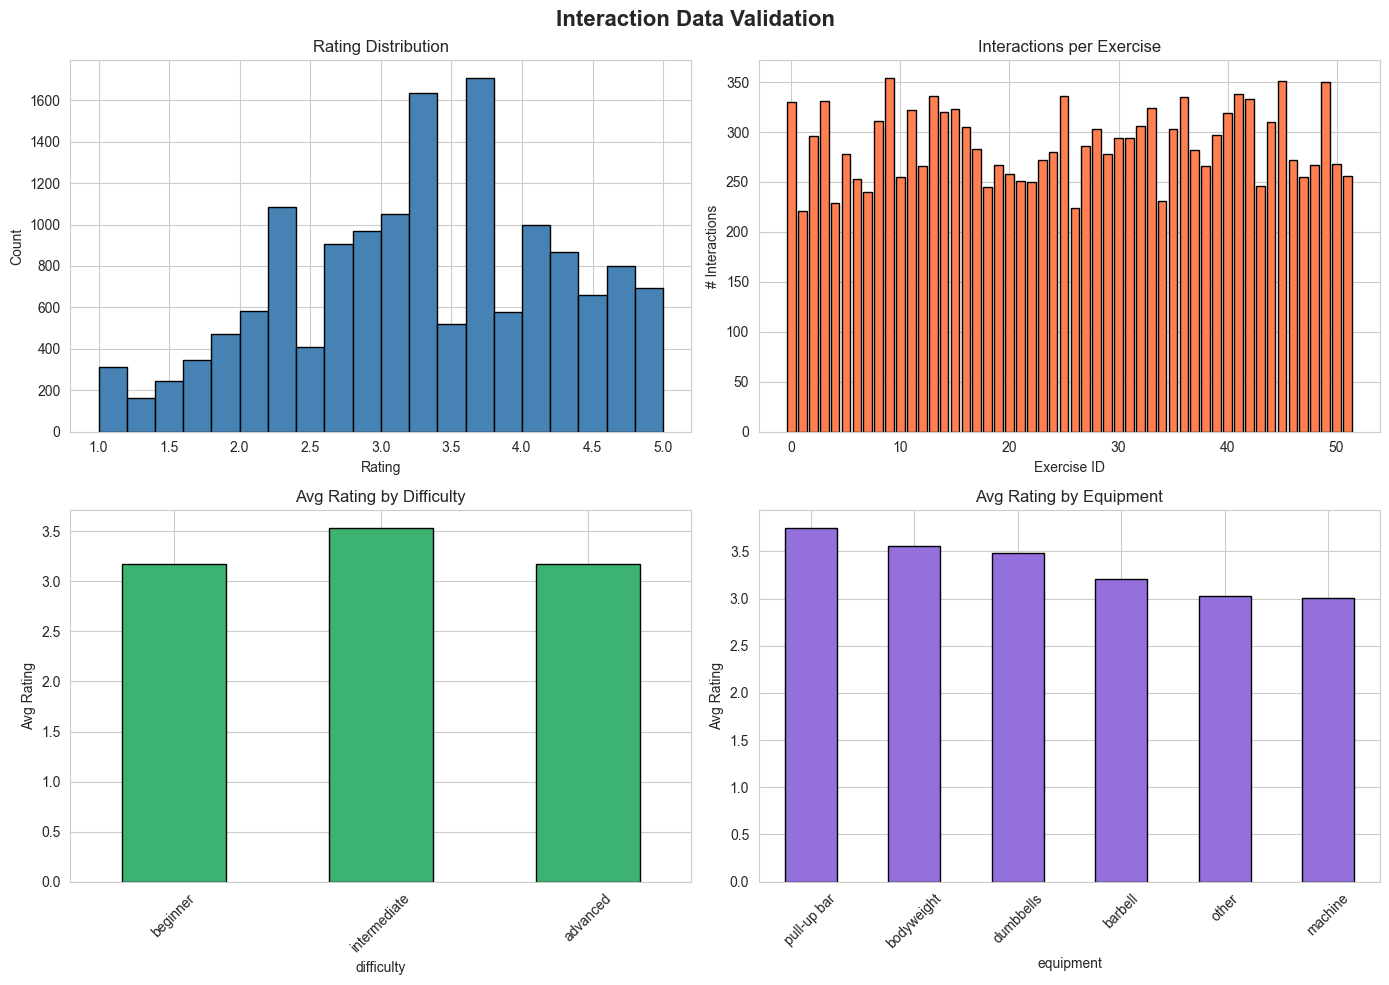

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Interaction Data Validation', fontsize=16, fontweight='bold')

# Rating distribution
axes[0,0].hist(interactions_df['rating'], bins=20, color='steelblue', edgecolor='black')
axes[0,0].set_title('Rating Distribution')
axes[0,0].set_xlabel('Rating')
axes[0,0].set_ylabel('Count')

# Interactions per exercise
ex_counts = interactions_df['exercise_id'].value_counts().sort_index()
axes[0,1].bar(range(len(ex_counts)), ex_counts.values, color='coral', edgecolor='black')
axes[0,1].set_title('Interactions per Exercise')
axes[0,1].set_xlabel('Exercise ID')
axes[0,1].set_ylabel('# Interactions')

# Average rating by exercise difficulty
merged = interactions_df.merge(exercises[['exercise_id', 'difficulty']], on='exercise_id')
diff_ratings = merged.groupby('difficulty')['rating'].mean().reindex(['beginner', 'intermediate', 'advanced'])
diff_ratings.plot.bar(ax=axes[1,0], color='mediumseagreen', edgecolor='black')
axes[1,0].set_title('Avg Rating by Difficulty')
axes[1,0].set_ylabel('Avg Rating')
axes[1,0].tick_params(axis='x', rotation=45)

# Average rating by equipment
merged2 = interactions_df.merge(exercises[['exercise_id', 'equipment']], on='exercise_id')
equip_ratings = merged2.groupby('equipment')['rating'].mean().sort_values(ascending=False)
equip_ratings.plot.bar(ax=axes[1,1], color='mediumpurple', edgecolor='black')
axes[1,1].set_title('Avg Rating by Equipment')
axes[1,1].set_ylabel('Avg Rating')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../results/figures/05_interaction_validation.png', dpi=150, bbox_inches='tight')
plt.show()

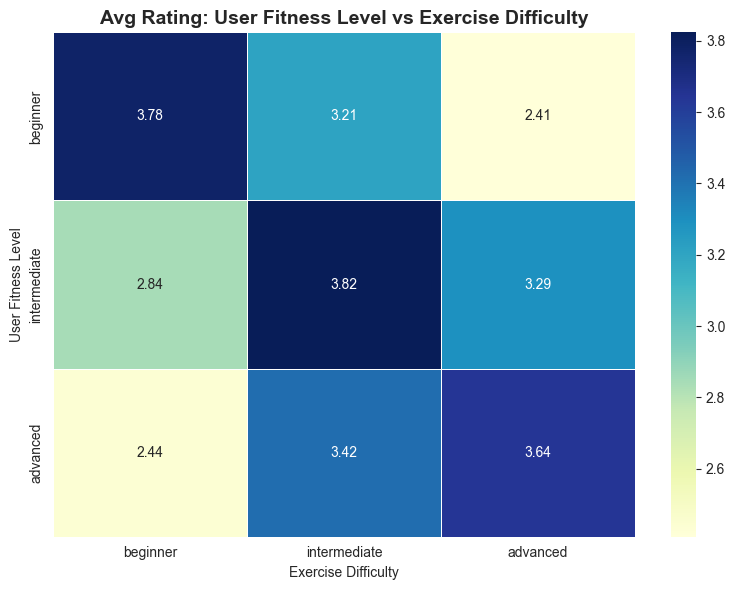

If the diagonal is brightest, our preference rules are working correctly!


In [8]:
# Key validation: Do beginners rate beginner exercises higher?
merged_full = interactions_df.merge(exercises[['exercise_id', 'difficulty']], on='exercise_id')
merged_full = merged_full.merge(users[['user_id', 'fitness_level']], on='user_id')

pivot = merged_full.groupby(['fitness_level', 'difficulty'])['rating'].mean().unstack()
pivot = pivot.reindex(index=['beginner', 'intermediate', 'advanced'],
                      columns=['beginner', 'intermediate', 'advanced'])

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlGnBu', linewidths=0.5)
plt.title('Avg Rating: User Fitness Level vs Exercise Difficulty', fontsize=14, fontweight='bold')
plt.xlabel('Exercise Difficulty')
plt.ylabel('User Fitness Level')
plt.tight_layout()
plt.savefig('../results/figures/06_level_difficulty_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print('If the diagonal is brightest, our preference rules are working correctly!')

## 5. Export Data

In [9]:
users.to_csv('../data/processed/user_profiles.csv', index=False)
interactions_df.to_csv('../data/processed/user_exercise_interactions.csv', index=False)

print('Exported:')
print(f'  User profiles: {len(users)} users -> data/processed/user_profiles.csv')
print(f'  Interactions: {len(interactions_df)} interactions -> data/processed/user_exercise_interactions.csv')
print()
print('Data is ready for modeling!')

Exported:
  User profiles: 1000 users -> data/processed/user_profiles.csv
  Interactions: 15000 interactions -> data/processed/user_exercise_interactions.csv

Data is ready for modeling!


## 6. Summary

### What we built:
- **1,000 synthetic users** with 7 attributes each
- **~15,000 user-exercise interactions** with ratings
- **5 preference rules** governing how users choose exercises:
  1. Difficulty-level matching
  2. Equipment compatibility
  3. Body part preference alignment
  4. Fitness goal alignment with movement type
  5. Age-appropriate adjustments

### Why synthetic data?
- No public fitness interaction dataset exists
- Our rules are transparent and documentable
- We can discuss limitations in our write-up (a research maturity signal!)

### Next: Notebook 03 — Content-Based Filtering Model